![](../images/TQ42_Logo_Black_Teal.svg)


# Welcome to TQ42!

## Examples for CVA_OPT


In [12]:
from tq42.client import TQ42Client
from tq42.experiment_run import ExperimentRun
from tq42.organization import list_all as list_all_organizations
from tq42.project import list_all as list_all_projects
from tq42.experiment import list_all as list_all_experiments
from tq42.experiment_run import ExperimentRunStatusProto
from tq42.algorithm import AlgorithmProto
from tq42.compute import HardwareProto
import json
import pandas

### Get your experiment id by descending the organization, project, experiment hierarchy

In [ ]:
tq42client = TQ42Client()
org_list = list_all_organizations(tq42client)
project_list = list_all_projects(client=tq42client, organization_id=org_list[0].id)
experiment_list = list_all_experiments(client=tq42client, project_id=project_list[1].id)
experiment_id = experiment_list[0].id

In [2]:
print(f"Running experiment within: Org {org_list[0].id}, Proj {project_list[1].id} and Exp {experiment_id}`")

### Set your func_eval_worker url
CVA_OPT is a black-box optimizer using evolutionary strategies (ES) meaning it does not know anything 
about the internal structure of the objective function which should be optimized. CVA_OPT sends 
candidate solutions to a so called function evaluation worker which then answers with 
the evaluated candidate solutions.

Here are some examples for func_eval_worker urls.
These examples are based on the python modules OptimizationTestFunctions and pymoo which implement academic test functions.

In [3]:
func_eval_worker_ip = '34.32.169.11'
# single-objective optimization
func_eval_worker_url_sphere = 'http://' + func_eval_worker_ip + ':8000/test_func_eval/Sphere'
# multi-objective optimization
func_eval_worker_url_zdt1 = 'http://' + func_eval_worker_ip + ':8000/test_func_eval/ZDT1'

### Single-objective example sphere function

#### Define your optimization run by setting
* objectives
* variables
* func_eval_worker_url
* parameters for CVA_OPT


In [4]:
cva_params = {}

##### Objectives
* the name of our objective is called like the function itself: Sphere
* the aim_type sets if the objective should be minimized (MINIMIZE) of maximized (MAXIMIZE)

In [5]:
cva_params['objectives'] = [{'name': 'Sphere', 'aim_type':'MINIMIZE'}]

##### Variables
Variables have a name and depending of their type lower and upper bounds or possible class values
in this example we want to optimize a two dimensional sphere function in the box [-1,1]x[-1,1]

In [6]:
cva_params['variables'] = []
cva_params['variables'].append({'name': 'x1', 'info_real':{'lower_bound':-1.0, 'upper_bound':1.0}})
cva_params['variables'].append({'name': 'x2', 'info_real':{'lower_bound':-1.0, 'upper_bound':1.0}})

##### func_eval_worker_url
We select our url for the sphere function defined above

In [7]:
cva_params['func_eval_worker_url'] = func_eval_worker_url_sphere

##### Parameters for CVA_OPT

In [8]:
cva_params['parameters'] = {}
# set the number of generations (iterations)
cva_params['parameters']['max_generation'] = 250
# set the ES specific parameters mue and lambda
cva_params['parameters']['mue'] = 15
cva_params['parameters']['lambda'] = 100

Please note that CVA_OPT will use max_generation * lambda many function evaluations, i.e.,
50 * 10 = 500 function evaluations to minimize the sphere function.

#### Create an experiment run

In [13]:
run = ExperimentRun.create(
    client=tq42client, 
    algorithm=AlgorithmProto.CVA_OPT, 
    experiment_id=experiment_id,
    compute=HardwareProto.SMALL, 
    parameters={'parameters': cva_params, 'inputs': {} }
)

##### Check its status and store the result once finished

In [14]:
run_result = run.poll()
print('status: ' + ExperimentRunStatusProto.Name(run_result.data.status))

status: COMPLETED


##### Get the result as pandas data frame

In [15]:
result_df = pandas.DataFrame(json.loads(getattr(getattr(run_result.data, 'result'), 'result_json'))['logs']['result'])
result_df

,x1,x2,Sphere
0,5.144655e-08,2.814545e-08,3.438914e-15


### Multi-objective example ZDT1 function

In [57]:
cva_params = {}

##### Set the two objectives

In [58]:
cva_params['objectives'] = []
cva_params['objectives'].append({'name': 'ZDT1_1', 'aim_type':'MINIMIZE'})
cva_params['objectives'].append({'name': 'ZDT1_2', 'aim_type':'MINIMIZE'})

##### Define the input variables. ZDT1 has 30 input variables (all with lower bound 0.0 and upper bound 1.0), so we define them in a for loop.

In [59]:
cva_params['variables'] = []
for i in range(30):
    cva_params['variables'].append({'name': 'x'+str(i+1), 'info_real': {'lower_bound': 0.0, 'upper_bound': 1.0}})

##### Set the func_eval_worker url

In [60]:
cva_params['func_eval_worker_url'] = func_eval_worker_url_zdt1

##### Set CVA_OPT parameters
The result of a multi-objective optimization consists of a Pareto front which is harder to derive than a solution in the single-objective case. So, we want to spend more function evaluations, in this case 25000 function evaluations by setting max_generation to 250 and lambda to 100.

In [61]:
cva_params['parameters'] = {'max_generation': 250, 'mue': 15, 'lambda': 100}

#### Create an experiment run

In [62]:
run = ExperimentRun.create(
    client=tq42client, 
    algorithm=AlgorithmProto.CVA_OPT, 
    experiment_id=experiment_id,
    compute=HardwareProto.SMALL, 
    parameters={'parameters': cva_params, 'inputs': {} }
)

##### Check its status and store the result once finished

In [63]:
run_result = run.poll()
print('status: ' + ExperimentRunStatusProto.Name(run_result.data.status))

status: COMPLETED


##### Get the result as pandas data frame and plot the Pareto front

<Axes: xlabel='ZDT1_1', ylabel='ZDT1_2'>

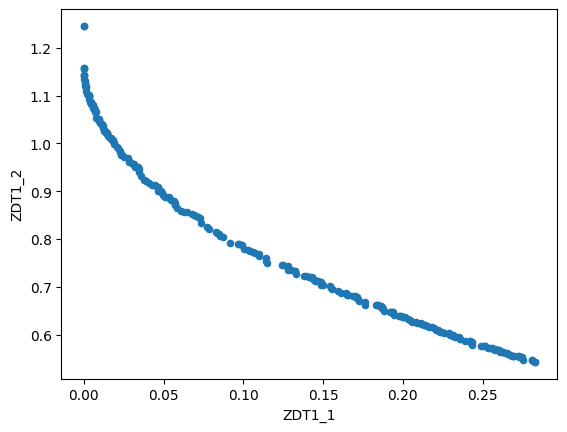

In [64]:
result_df = pandas.DataFrame(json.loads(getattr(getattr(run_result.data, 'result'), 'result_json'))['logs']['result'])
result_df.plot.scatter('ZDT1_1', 'ZDT1_2')